# Assignment 6: Neural Networks

# Problem 1: The dataset

Loading the MNIST dataset from `torchvision.datasets`:

In [92]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
	root='data',
	train=True,
	download=True,
	transform=ToTensor()
)

test_data = datasets.MNIST(
	root='data',
	train=False,
	download=True,
	transform=ToTensor()
)

Wrapping the dataset in a `DataLoader`:

In [93]:
train_loader = DataLoader(
	train_data,
	batch_size=64,
)

test_loader = DataLoader(
	test_data,
	batch_size=64,
)

Plotting the first images from the training set:

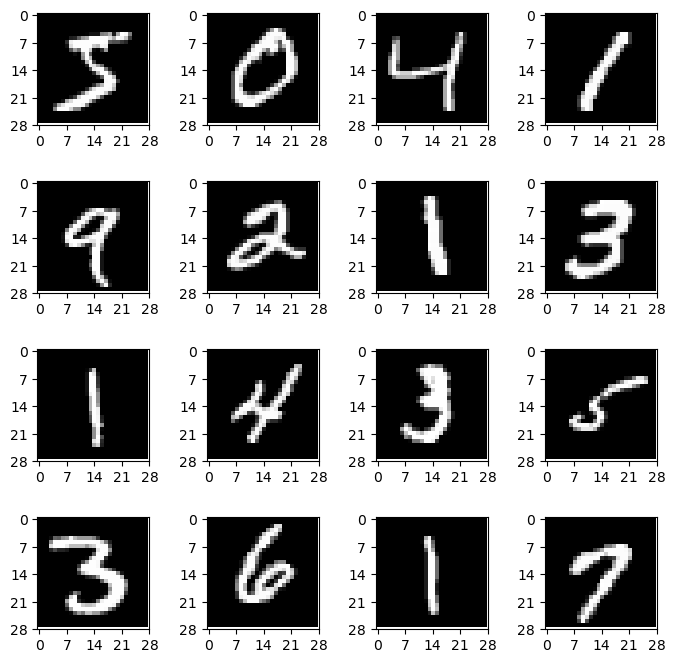

In [94]:
import matplotlib.pyplot as plt

images, _ = next(iter(train_loader))

ppr = 4  # plots per row

fig, ax = plt.subplots(
	ppr, ppr,
	figsize=(ppr * 2, ppr * 2)
)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(ppr ** 2):
	ax[i // ppr, i % ppr].imshow(
		images[i].squeeze(),
		cmap='gray'
	)
	ax[i // ppr, i % ppr].set_xticks(
		range(0, 29, 7))
	ax[i // ppr, i % ppr].set_yticks(
		range(0, 29, 7))

plt.savefig('figures/mnist.png')

# Problem 2: Single hidden layer

Creating the model for a single hidden layer with ReLU activation:

In [95]:
device = (
	"cuda"
	if torch.cuda.is_available()
	else "mps"
	if torch.backends.mps.is_available()
	else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [96]:
class FNN(nn.Module):
	def __init__(self):
		super(FNN, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28 * 28, 512),
			nn.ReLU(),
			nn.Linear(512, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits


model = FNN().to(device)

Defining the training of the model using the SGD optimizer and CrossEntropy loss:

In [97]:
lr = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	model.parameters(), lr=lr
)

In [98]:
def train(dataloader, model, loss_fn, optimizer,
          logging=True):
	size = len(dataloader.dataset)
	model.train()
	for batch, (X, y) in enumerate(dataloader):
		X, y = X.to(device), y.to(device)

		pred = model(X)
		loss = loss_fn(pred, y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if logging and batch % 100 == 0:
			loss, current = loss.item(), batch * len(X)
			print(
				f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]"
			)

Defining the testing of the model performance against the `test_data`:

In [99]:
def test(dataloader, model, loss_fn,
         logging=True):
	size = len(dataloader.dataset)
	num_batches = len(dataloader)
	model.eval()
	test_loss, correct = 0, 0
	with (torch.no_grad()):
		for X, y in dataloader:
			X, y = X.to(device), y.to(device)
			pred = model(X)
			test_loss += loss_fn(pred, y).item()
			correct += (
					pred.argmax(1) == y
			).type(torch.float).sum().item()
	test_loss /= num_batches
	accuracy = round(correct / size * 100, 4)
	if logging:
		print(f"\n accuracy: {accuracy:>0.1f}%")
		print(f" test loss: {test_loss:>8f}\n")
	return accuracy, test_loss

Training the model for 10 epochs and evaluating its performance:

In [100]:
epochs = range(1, 11)

accuracy_list = []
for t in epochs:
	print(f"training epoch {t}...")

	train(train_loader, model, loss_fn, optimizer,
	      logging=False)
	accuracy, test_loss = test(
		test_loader, model, loss_fn
	)

	accuracy_list.append(accuracy)
	print(f"-------------------------------")
	
torch.save(
	model.state_dict(),
	"models/single_layer.pth"
)
print("training complete, model saved")

training epoch 1...

 accuracy: 66.5%
 test loss: 2.076953

-------------------------------
training epoch 2...

 accuracy: 73.5%
 test loss: 1.775566

-------------------------------
training epoch 3...

 accuracy: 77.7%
 test loss: 1.437716

-------------------------------
training epoch 4...

 accuracy: 80.7%
 test loss: 1.152379

-------------------------------
training epoch 5...

 accuracy: 82.7%
 test loss: 0.950586

-------------------------------
training epoch 6...

 accuracy: 84.2%
 test loss: 0.813721

-------------------------------
training epoch 7...

 accuracy: 85.1%
 test loss: 0.718670

-------------------------------
training epoch 8...

 accuracy: 85.8%
 test loss: 0.649988

-------------------------------
training epoch 9...

 accuracy: 86.4%
 test loss: 0.598435

-------------------------------
training epoch 10...

 accuracy: 87.0%
 test loss: 0.558458

-------------------------------
training complete, model saved


Defining the export of the accuracy data to a csv file:

In [101]:
import csv


def save_accuracy_data(
		filename, accuracy_list
):
	with open(filename, mode='w') as file:
		writer = csv.writer(file)
		writer.writerow(["epoch", "accuracy"])
		for epoch, accuracy in enumerate(
				accuracy_list):
			writer.writerow([epoch + 1, accuracy])

Saving and plotting the accuracy data:

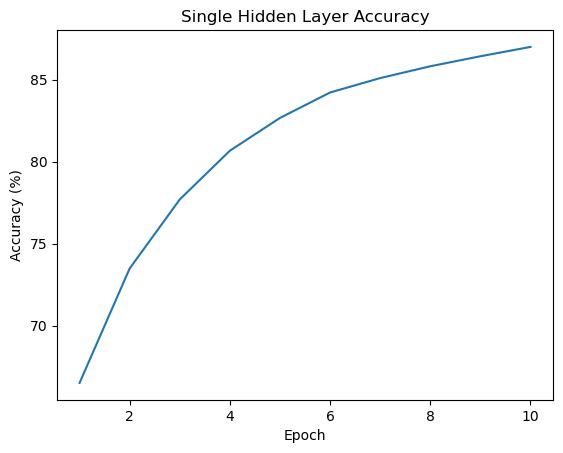

In [102]:
import matplotlib.pyplot as plt

save_accuracy_data(
	"models/single_layer_accuracy.csv",
	accuracy_list
)
plt.plot(epochs, accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Single Hidden Layer Accuracy")
plt.savefig(
	"figures/single_layer_accuracy.png")

# Problem 3: Two hidden layers

Redeclaring the model with two hidden layers:

In [103]:
class FNN2(nn.Module):
	def __init__(self):
		super(FNN2, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28 * 28, 500),
			nn.ReLU(),
			nn.Linear(500, 300),
			nn.ReLU(),
			nn.Linear(300, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits


model = FNN2().to(device)

Redefine the optimizer with L2 regularization:

In [104]:
optimizer = torch.optim.SGD(
	model.parameters(),
	lr=0.1,
	weight_decay=1e-4
)

Train the model for 40 epochs and evaluate its performance:

In [105]:
epochs = range(1, 41)

accuracy_list = []
for t in epochs:
	print(f"training epoch {t}...")

	train(train_loader, model, loss_fn, optimizer,
	      logging=False)
	accuracy, test_loss = test(
		test_loader, model, loss_fn
	)

	accuracy_list.append(accuracy)
	print(f"-------------------------------")

torch.save(model.state_dict(),
           "models/two_layer.pth")
print("training complete, model saved")

training epoch 1...

 accuracy: 93.1%
 test loss: 0.219697

-------------------------------
training epoch 2...

 accuracy: 95.6%
 test loss: 0.145254

-------------------------------
training epoch 3...

 accuracy: 96.5%
 test loss: 0.111267

-------------------------------
training epoch 4...

 accuracy: 96.8%
 test loss: 0.098096

-------------------------------
training epoch 5...

 accuracy: 97.3%
 test loss: 0.086938

-------------------------------
training epoch 6...

 accuracy: 97.4%
 test loss: 0.080738

-------------------------------
training epoch 7...

 accuracy: 97.5%
 test loss: 0.076485

-------------------------------
training epoch 8...

 accuracy: 97.7%
 test loss: 0.072548

-------------------------------
training epoch 9...

 accuracy: 97.8%
 test loss: 0.071075

-------------------------------
training epoch 10...

 accuracy: 97.9%
 test loss: 0.070799

-------------------------------
training epoch 11...

 accuracy: 97.9%
 test loss: 0.070921

------------------

Saving and plotting the accuracy data:

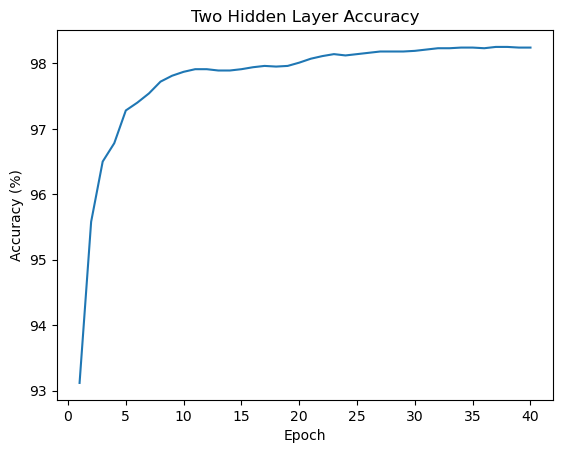

In [106]:
save_accuracy_data(
	"models/two_layer_accuracy.csv",
	accuracy_list
)
plt.plot(epochs, accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Two Hidden Layer Accuracy")
plt.savefig(
	"figures/two_layer_accuracy.png")

# Problem 4: Convolutional Neural Network

Redeclaring the model with convolutional layers:

In [107]:
class CNN(nn.Module):
	def __init__(self):
		super(CNN, self).__init__()
		self.conv1 = nn.Conv2d(
			1, 32,
			kernel_size=3,
			stride=1,
			padding=1
		)
		self.conv2 = nn.Conv2d(
			32, 64,
			kernel_size=3,
			stride=1,
			padding=1
		)
		self.fc1 = nn.Linear(
			64 * 7 * 7,
			128
		)
		self.fc2 = nn.Linear(128, 10)

	def forward(self, x):
		x = torch.relu(self.conv1(x))
		x = torch.max_pool2d(x, 2)
		x = torch.relu(self.conv2(x))
		x = torch.max_pool2d(x, 2)
		x = x.view(-1, 64 * 7 * 7)
		x = torch.relu(self.fc1(x))
		x = self.fc2(x)
		return x


model = CNN().to(device)

Redefine the optimizer:

In [108]:
optimizer = torch.optim.SGD(
	model.parameters(),
	lr=0.01,
	weight_decay=1e-4
)

Train the model for 40 epochs and evaluate its performance:

In [109]:
epochs = range(1, 41)

accuracy_list = []
for t in epochs:
	print(f"training epoch {t}...")

	train(train_loader, model, loss_fn, optimizer,
	      logging=False)
	accuracy, test_loss = test(
		test_loader, model, loss_fn
	)

	accuracy_list.append(accuracy)
	print(f"-------------------------------")

torch.save(model.state_dict(), "models/cnn.pth")
print("training complete, model saved")

training epoch 1...

 accuracy: 87.5%
 test loss: 0.390898

-------------------------------
training epoch 2...

 accuracy: 91.8%
 test loss: 0.261708

-------------------------------
training epoch 3...

 accuracy: 93.7%
 test loss: 0.191845

-------------------------------
training epoch 4...

 accuracy: 95.3%
 test loss: 0.146372

-------------------------------
training epoch 5...

 accuracy: 96.2%
 test loss: 0.117370

-------------------------------
training epoch 6...

 accuracy: 96.8%
 test loss: 0.099382

-------------------------------
training epoch 7...

 accuracy: 97.3%
 test loss: 0.086455

-------------------------------
training epoch 8...

 accuracy: 97.5%
 test loss: 0.078073

-------------------------------
training epoch 9...

 accuracy: 97.7%
 test loss: 0.071600

-------------------------------
training epoch 10...

 accuracy: 97.9%
 test loss: 0.066191

-------------------------------
training epoch 11...

 accuracy: 98.1%
 test loss: 0.061709

------------------

Saving and plotting the accuracy data:

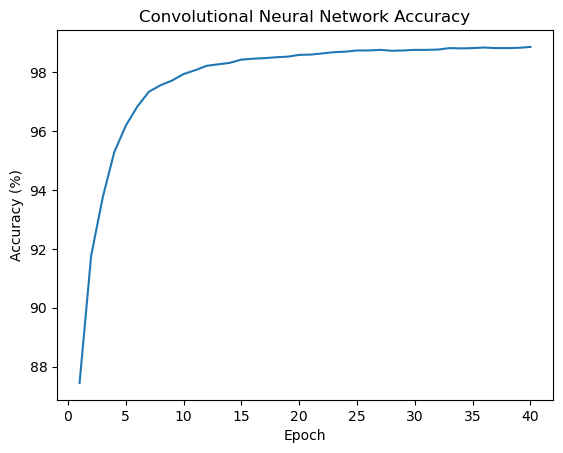

In [110]:
save_accuracy_data("models/cnn_accuracy.csv",
                   accuracy_list)
plt.plot(epochs, accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Convolutional Neural Network Accuracy")
plt.savefig("figures/cnn_accuracy.png")